## Link census tracts to toc tiers
* Find what proportion belongs within a particular tier

In [1]:
import intake
import numpy as np
import pandas as pd
import geopandas as gpd
import utils

In [2]:
catalog = intake.open_catalog("../catalogs/*.yml")

bucket_name = 'city-planning-entitlements'

## Find out how many parcels are within each tract, and its relative proportion of the tract
* Check: sum of parcel area within tract should be <= 100%
* If parcel file includes roads, then those areas would be excluded from the tract

In [3]:
la_parcels = gpd.read_file(f'zip+s3://{bucket_name}/gis/raw/la_parcels.zip').to_crs({'init':'epsg:2229'})

la_parcels = (
    la_parcels.assign(parcel_sqft = la_parcels.geometry.area)
                .rename(columns = {'geometry':'parcel_geom'})
)

tracts = catalog.census_tracts.read().to_crs({'init':'epsg:2229'})

tracts = (
    tracts[['GEOID10', 'geometry']]
    .rename(columns = {'GEOID10': 'GEOID', 'geometry':'tract_geom'})
    .assign(tract_sqft = tracts.geometry.area)
)

crosswalk_parcels_tracts = pd.read_parquet(f's3://{bucket_name}/data/crosswalk_parcels_tracts.parquet')

In [4]:
parcel_geom = pd.merge(la_parcels, crosswalk_parcels_tracts, on = 'AIN', validate = '1:1')

In [5]:
tract_geom = pd.merge(parcel_geom, tracts, on = 'GEOID', validate = 'm:1')

In [6]:
df = tract_geom.groupby(['GEOID', 'tract_sqft']).agg({'parcel_sqft':'sum'}).reset_index()
df['total_pct'] = df.parcel_sqft / df.tract_sqft

In [7]:
print(len(df))
print(len(df[df.total_pct <= 1]))
print(len(df[df.total_pct > 1]))

1007
701
306


In [8]:
wrong = df[df.total_pct > 1]

In [15]:
geoid = ['06037102104']
fix = wrong[wrong.GEOID.isin(geoid)]

wrong_parcels = parcel_geom[parcel_geom.GEOID.isin(geoid)]

In [22]:
wrong_tracts = pd.merge(fix, tracts, on = ['GEOID', 'tract_sqft'], how = 'inner')
wrong_tracts = gpd.GeoDataFrame(wrong_tracts)
wrong_tracts = wrong_tracts.set_geometry('tract_geom')
wrong_tracts.crs = {'init':'epsg:2229'}

wrong_parcels = gpd.GeoDataFrame(wrong_parcels)
wrong_parcels = wrong_parcels.set_geometry('parcel_geom')
wrong_parcels.crs = {'init':'epsg:2229'}

In [25]:
wrong_tracts.to_file(driver = 'GeoJSON', filename = '../gis/wrong_tracts.geojson')
wrong_parcels.to_file(driver = 'GeoJSON', filename = '../gis/wrong_parcels.geojson')

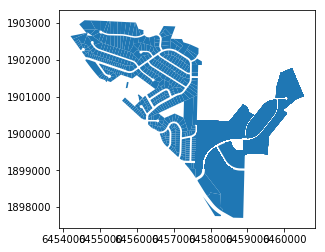

In [20]:
wrong_parcels.plot()

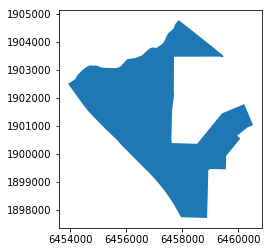

In [23]:
wrong_tracts.plot()

## Join parcels to tracts

In [ ]:
parcels = gpd.read_file(
    f"s3://{bucket_name}/gis/intermediate/toc_eligible_parcels_with_entitlements.geojson"
).to_crs({'init':'epsg:2229'})

#toc_tiers = utils.reconstruct_toc_tiers_file().to_crs({'init':'epsg:2229'})

#df = utils.parcels_join_toc_tiers(parcels, toc_tiers)

In [ ]:
parcels.dtypes

In [ ]:
m1 = pd.merge(df, crosswalk_parcels_tracts, on = 'AIN', how = 'left', validate = '1:1')

## Scratch work

In [ ]:
# Join parcels to census tracts
m1 = pd.merge(parcels, crosswalk_parcels_tracts, on = 'AIN', how = 'inner')

In [ ]:
# Join tracts to TOC tiers
m2 = pd.merge(tracts, crosswalk_tracts_tiers, on = 'GEOID', how = 'inner')

In [ ]:
geoid = ['06037207301']
crosswalk_tracts_tiers[crosswalk_tracts_tiers.GEOID.isin(geoid)]

In [ ]:
crosswalk_tracts_tiers.groupby(['GEOID', 'intersect_tier']).agg({'intersect_sqft':'sum'}).reset_index()

In [ ]:
# Find what proportion of tract sqmi intersects with TOC tier
m2 = (m2
      .assign(pct_area = m2.intersect_sqft / m2.tract_sqft)
      .drop(columns = ['tract_sqft', 'intersect_sqft'])
)

In [ ]:
m2.pct_area.describe()